# <strong>Cats v.s. Dogs - Image Classification</strong> Using CNNs

Erickson Figueroa <br>
Data Science, Machine Learning & AI <br>

<img src="./CNNs.png" withd = 500 height = "300">

## 1. <b>Importing Libraries</b>

In [43]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Tensor flow ready integrated with Keras
import tensorflow  as tf

# Models and metrics
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

# check tensorflow version
print("TensorFlow version:", tf.__version__)

# using operating system-dependent functionality
import os

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

TensorFlow version: 2.16.1


## 2. <b>Importing the data</b>
The Dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility.

In [10]:
# URL of the dataset containing filtered images of cats and dogs
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download and extract the dataset from the given URL
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# Define the base directory of the extracted dataset
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Define the paths for training and validation datasets
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Define batch size and image dimensions
BATCH_SIZE = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

# Load and preprocess the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,           # Path to the training data
    shuffle=True,        # Shuffle the data to ensure random order
    batch_size=BATCH_SIZE, # Number of images to be yielded from the generator per batch
    image_size=IMG_SIZE  # Resize images to the specified height and width
)

# Load and preprocess the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,      # Path to the validation data
    shuffle=True,        # Shuffle the data to ensure random order
    batch_size=BATCH_SIZE, # Number of images to be yielded from the generator per batch
    image_size=IMG_SIZE  # Resize images to the specified height and width
)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Show some images

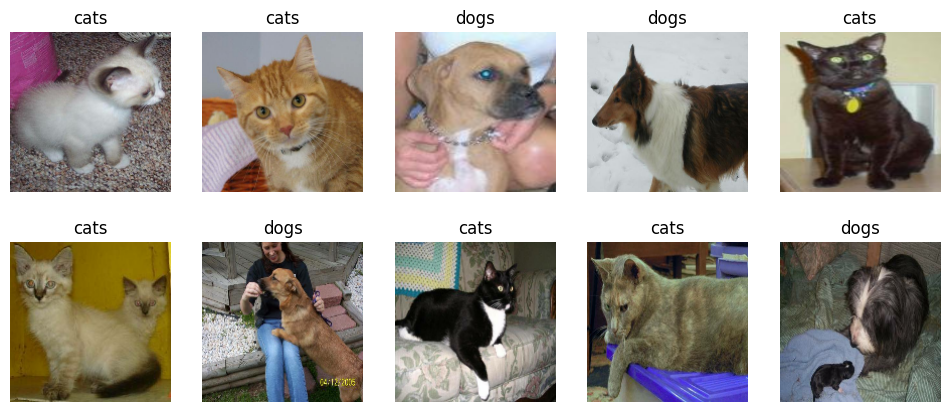

In [11]:
# Retrieve the class names from the training dataset
class_names = train_dataset.class_names

# Create a new figure with a specified size
plt.figure(figsize=(12, 5))

# Take one batch of images and labels from the training dataset
for images, labels in train_dataset.take(1):
    # Iterate over the first 10 images in the batch
    for i in range(min(10, len(images))):
        # Create a subplot in a 2x5 grid for each image
        ax = plt.subplot(2, 5, i + 1)
        
        # Display the image, converting the tensor to a numpy array and casting to uint8
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Set the title of the subplot to the class name of the corresponding label
        plt.title(class_names[labels[i]])
        
        # Turn off the axis for a cleaner look
        plt.axis("off")

# Show the plot
plt.show()

### Split the data
As the original dataset doesn't contain a test set, We will create one. To do so, we have to determine how many batches of data are available in the validation set using <strong>tf.data.experimental.cardinality</strong>, then move 20% of them to a test set.

In [12]:
# Determine the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_dataset).numpy()

# Calculate 20% of the validation batches for the test set
test_batches = int(0.2 * val_batches)

# Create the test dataset by taking 20% of the validation dataset
test_dataset = validation_dataset.take(test_batches)

# Create the new validation dataset by skipping the batches used for the test set
validation_dataset = validation_dataset.skip(test_batches)

# Print the number of batches in the new validation and test sets
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking.

To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [13]:
# Configure the datasets for performance using buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## A basic Keras model
### Model version: VGG-1

In [15]:
# Define a model with 1 VGG block
model = Sequential([
    # Rescale the input images from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(160, 160, 3)),
    
    # First VGG block: Convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and He uniform initializer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    
    # MaxPooling layer to reduce the spatial dimensions (downsample) by a factor of 2
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the 3D output from the convolutional block to 1D for the fully connected layers
    layers.Flatten(),
    
    # Dense (fully connected) layer with 128 units, ReLU activation, and He uniform initializer
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    
    # Output layer with 1 unit and sigmoid activation for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with SGD optimizer, binary cross-entropy loss, and accuracy metric
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    26,214,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,553 (100.00 MB)

 Trainable params: 26,215,553 (100.00 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
# Train the model
epochs = 20  # Number of training epochs

# Fit the model on the training dataset, validating on the validation dataset
history = model.fit(
    # Training dataset
    train_dataset,  
    # Validation dataset
    validation_data=validation_dataset, 
    # Number of epochs to train
    epochs=epochs                    
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.4869 - loss: 0.8572 - val_accuracy: 0.5458 - val_loss: 0.6809
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.5458 - loss: 0.6816 - val_accuracy: 0.5334 - val_loss: 0.6881
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.5434 - loss: 0.6856 - val_accuracy: 0.5606 - val_loss: 0.6757
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.5884 - loss: 0.6726 - val_accuracy: 0.5705 - val_loss: 0.6767
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.5770 - loss: 0.6710 - val_accuracy: 0.5631 - val_loss: 0.6830
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.6162 - loss: 0.6546 - val_accuracy: 0.5681 - val_loss: 0.6770
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.6132 - loss: 0.6485 - val_accuracy: 0.6139 - val_loss: 0.6511
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.5982 - loss: 0.6617 - val_accu

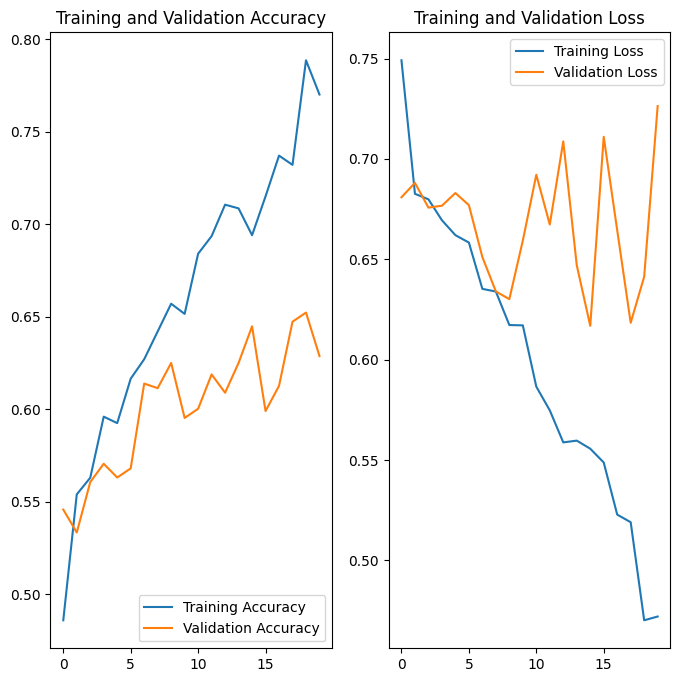

In [18]:
# Visualize training history

# Extract accuracy metrics from the history object
acc = history.history['accuracy']         # Training accuracy
val_acc = history.history['val_accuracy'] # Validation accuracy

# Extract loss metrics from the history object
loss = history.history['loss']             # Training loss
val_loss = history.history['val_loss']     # Validation loss

epochs_range = range(epochs)  # Number of epochs

# Plotting accuracy metrics
plt.figure(figsize=(8, 8))  # Set the figure size
plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add legend to the plot
plt.title('Training and Validation Accuracy')  # Add title to the plot

# Plotting loss metrics
plt.subplot(1, 2, 2)  # Create subplot 2 in a 1x2 grid
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add legend to the plot
plt.title('Training and Validation Loss')  # Add title to the plot

plt.show()  # Display the plot

### Model version: VGG-2

In [69]:
# Define a model with 2 VGG blocks

# Initialize a sequential model
model = Sequential([
    
    # Rescale the input images from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(160, 160, 3)),
    
    # First VGG block: Convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and He uniform initializer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    
    # MaxPooling layer to reduce the spatial dimensions (downsample) by a factor of 2
    layers.MaxPooling2D((2, 2)),
    
    # Second VGG block: Convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and He uniform initializer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    
    # MaxPooling layer to reduce the spatial dimensions (downsample) by a factor of 2
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the 3D output from the convolutional blocks to 1D for the fully connected layers
    layers.Flatten(),
    
    # Dense (fully connected) layer with 128 units, ReLU activation, and He uniform initializer
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    
    # Output layer with 1 unit and sigmoid activation for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with SGD optimizer, binary cross-entropy loss, and accuracy metric
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model

# Number of training epochs
epochs = 20

# Fit the model on the training dataset, validating on the validation dataset
history = model.fit(
    train_dataset,                       # Training dataset
    validation_data=validation_dataset,  # Validation dataset
    epochs=epochs                        # Number of epochs to train
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.5103 - loss: 0.7284 - val_accuracy: 0.6002 - val_loss: 0.6721
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.5729 - loss: 0.6731 - val_accuracy: 0.6163 - val_loss: 0.6612
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.5860 - loss: 0.6667 - val_accuracy: 0.6275 - val_loss: 0.6405
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.6237 - loss: 0.6496 - val_accuracy: 0.6361 - val_loss: 0.6447
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.6332 - loss: 0.6384 - val_accuracy: 0.6720 - val_loss: 0.6256
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.6875 - loss: 0.6108 - val_accuracy: 0.6584 - val_loss: 0.6106
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.6817 - loss: 0.5904 - val_accuracy: 0.6386 - val_loss: 0.6229
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.7175 - loss: 0.5545 - val_accu

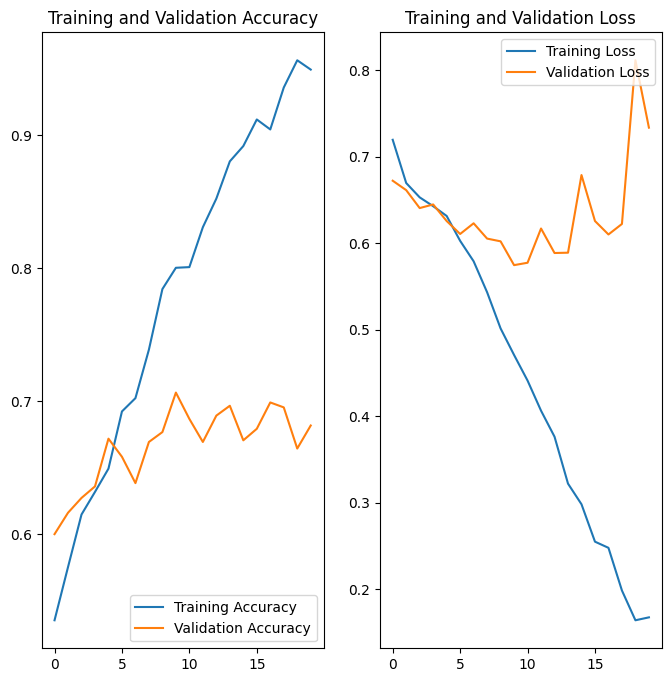

In [70]:
# Visualize training history

# Extract accuracy metrics from the history object
acc = history.history['accuracy']         # Training accuracy
val_acc = history.history['val_accuracy'] # Validation accuracy

# Extract loss metrics from the history object
loss = history.history['loss']             # Training loss
val_loss = history.history['val_loss']     # Validation loss

epochs_range = range(epochs)  # Number of epochs

# Plotting accuracy metrics
plt.figure(figsize=(8, 8))  # Set the figure size
plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add legend to the plot
plt.title('Training and Validation Accuracy')  # Add title to the plot

# Plotting loss metrics
plt.subplot(1, 2, 2)  # Create subplot 2 in a 1x2 grid
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add legend to the plot
plt.title('Training and Validation Loss')  # Add title to the plot

plt.show()  # Display the plot

### Model version: VGG-3

In [21]:
# Define a model with 3 VGG blocks

# Initialize a sequential model
model = Sequential([
    # Rescale the input images from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(160, 160, 3)),
    
    # First VGG block: Convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and He uniform initializer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    
    # MaxPooling layer to reduce the spatial dimensions (downsample) by a factor of 2
    layers.MaxPooling2D((2, 2)),
    
    # Second VGG block: Convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and He uniform initializer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    
    # MaxPooling layer to reduce the spatial dimensions (downsample) by a factor of 2
    layers.MaxPooling2D((2, 2)),
    
    # Third VGG block: Convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and He uniform initializer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    
    # MaxPooling layer to reduce the spatial dimensions (downsample) by a factor of 2
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the 3D output from the convolutional blocks to 1D for the fully connected layers
    layers.Flatten(),
    
    # Dense (fully connected) layer with 128 units, ReLU activation, and He uniform initializer
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    
    # Output layer with 1 unit and sigmoid activation for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with SGD optimizer, binary cross-entropy loss, and accuracy metric
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model

# Number of training epochs
epochs = 20

# Fit the model on the training dataset, validating on the validation dataset
history = model.fit(
    train_dataset,                   # Training dataset
    validation_data=validation_dataset,  # Validation dataset
    epochs=epochs                    # Number of epochs to train
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.4976 - loss: 0.7319 - val_accuracy: 0.5780 - val_loss: 0.6768
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.6027 - loss: 0.6595 - val_accuracy: 0.6262 - val_loss: 0.6438
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.6349 - loss: 0.6397 - val_accuracy: 0.6621 - val_loss: 0.6305
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.6527 - loss: 0.6229 - val_accuracy: 0.6609 - val_loss: 0.6213
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.6929 - loss: 0.5951 - val_accuracy: 0.6163 - val_loss: 0.6339
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.6795 - loss: 0.5815 - val_accuracy: 0.6473 - val_loss: 0.6383
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.7323 - loss: 0.5625 - val_accuracy: 0.6856 - val_loss: 0.5896
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.7619 - loss: 0.5080 - val_accu

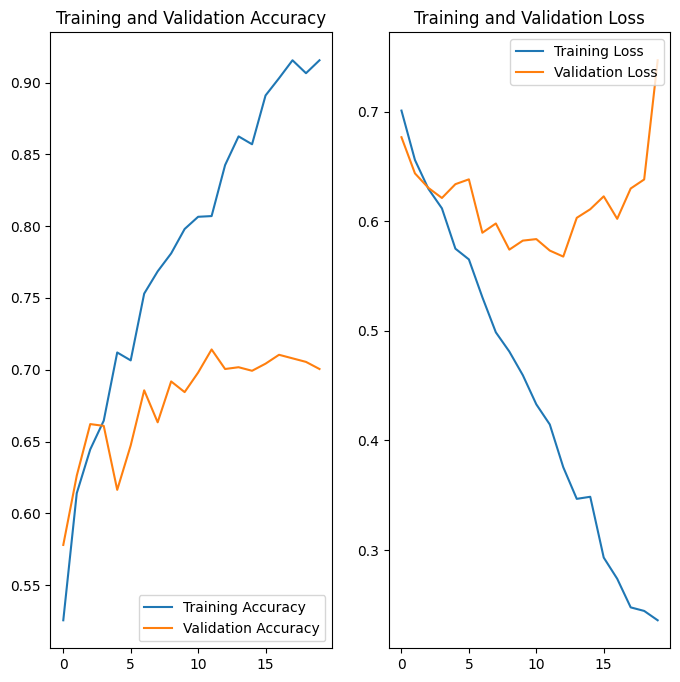

In [22]:
# Visualize training history

# Extract accuracy metrics from the history object
acc = history.history['accuracy']         # Training accuracy
val_acc = history.history['val_accuracy'] # Validation accuracy

# Extract loss metrics from the history object
loss = history.history['loss']             # Training loss
val_loss = history.history['val_loss']     # Validation loss

epochs_range = range(epochs)  # Number of epochs

# Plotting accuracy metrics
plt.figure(figsize=(8, 8))  # Set the figure size
plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add legend to the plot
plt.title('Training and Validation Accuracy')  # Add title to the plot

# Plotting loss metrics
plt.subplot(1, 2, 2)  # Create subplot 2 in a 1x2 grid
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add legend to the plot
plt.title('Training and Validation Loss')  # Add title to the plot

plt.show()  # Display the plot

### Model improvements
- Data augmentation
- Dropouts

In [77]:
# data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal",  # Randomly flip images horizontally
                        input_shape=(img_height, img_width, 3)),  # Input shape of the images
        layers.RandomRotation(0.1),  # Randomly rotate images within 0.1 radians
        layers.RandomZoom(0.1),  # Randomly zoom into images up to 10%
    ]
)

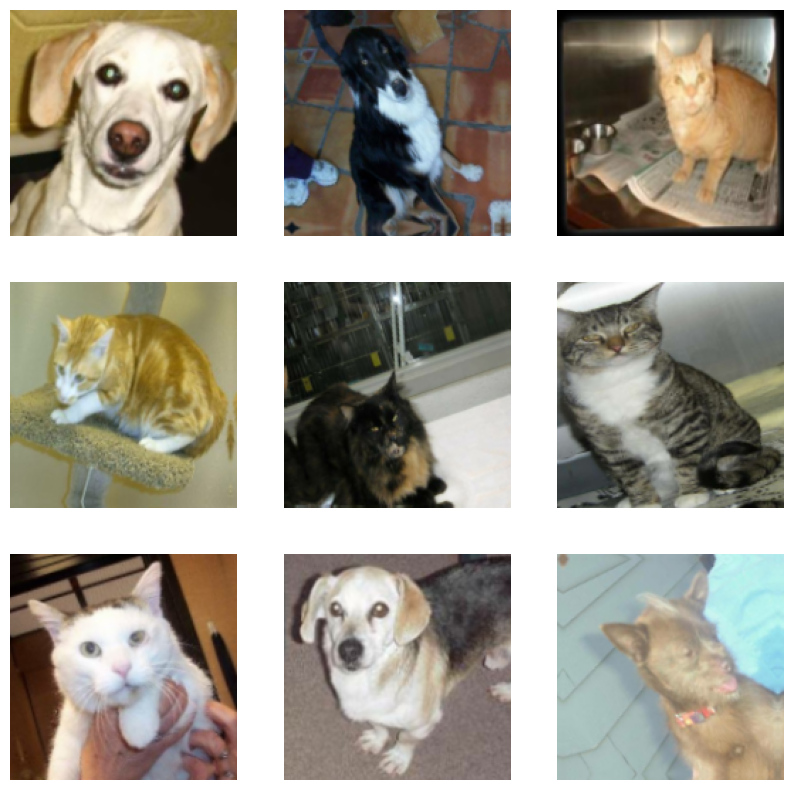

In [90]:
# show some augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    augmented_images = data_augmentation(images)  # Apply data augmentation to the batch of images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))  # Display augmented image
        plt.axis("off")
plt.show()

In [92]:
# Define a model with 1 VGG block
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary after building with a sample input shape
model.build((None, 160, 160, 3))  # Sample input shape (batch_size, img_height, img_width, channels)
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_13 (Rescaling)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 40, 40, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,658,049 (6.32 MB)

 Trainable params: 1,658,049 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# train the model
epochs=50
history = model.fit(
train_dataset,
validation_data=validation_dataset,
epochs=epochs
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.4971 - loss: 0.8223 - val_accuracy: 0.5557 - val_loss: 0.6876
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - accuracy: 0.5470 - loss: 0.6909 - val_accuracy: 0.5495 - val_loss: 0.6867
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.5399 - loss: 0.6890 - val_accuracy: 0.6027 - val_loss: 0.6805
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.5466 - loss: 0.6901 - val_accuracy: 0.6089 - val_loss: 0.6781
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.5756 - loss: 0.6794 - val_accuracy: 0.6151 - val_loss: 0.6761
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.5893 - loss: 0.6710 - val_accuracy: 0.6114 - val_loss: 0.6729
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.5738 - loss: 0.6801 - val_accuracy: 0.6064 - val_loss: 0.6697
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.6034 - loss: 0.6677 - val_accu

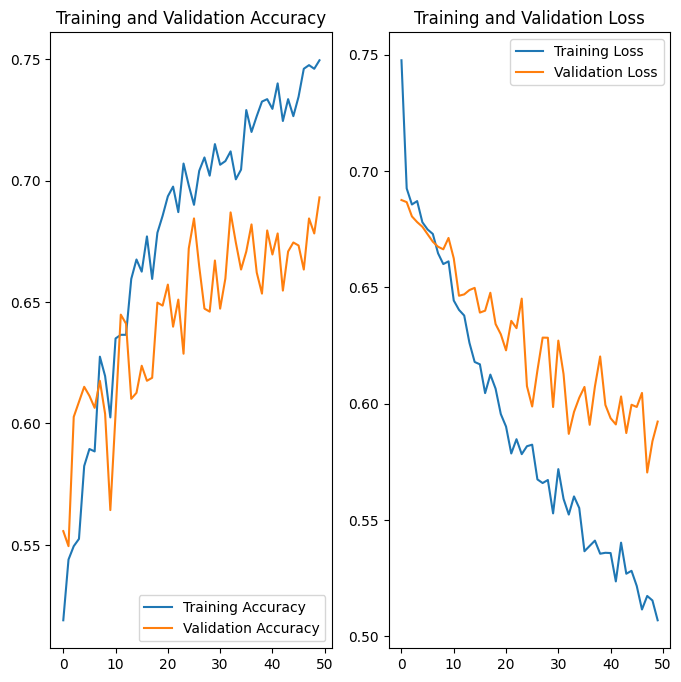

In [95]:
# visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Overfitting still an issue potentially because the training data dataset is too small to model variablity in the dataset. Let's try transfer learning to take advantage of one of the pretrained models.

## Transfer Learning with MobileNet V2

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

### Instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet and excluding the top classification layers

In [44]:
# Define constants
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32

# Load the MobileNetV2 model with pre-trained ImageNet weights, excluding the top layers
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


# Freeze the convolutional base to prevent them from being updated during training
base_model.trainable = False

# Add a global spatial average pooling layer
global_average_layer = layers.GlobalAveragePooling2D()

# Add a dense layer for classification with sigmoid activation function
prediction_layer = layers.Dense(1, activation='sigmoid')

# Build the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # data_augmentation defined in the previous steps
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)  # Adding dropout for regularization
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=optimizers.Adam(learning_rate=base_learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Print model summary to see the architecture
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train the model MobileNetV2

In [45]:
# Train the model
initial_epochs = 10
history = model.fit(train_dataset,  # train_dataset efined and preprocessed
                    epochs=initial_epochs,
                    validation_data=validation_dataset)  # validation_dataset defined and preprocessed


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - accuracy: 0.5798 - loss: 0.7442 - val_accuracy: 0.7463 - val_loss: 0.5337
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - accuracy: 0.7391 - loss: 0.5322 - val_accuracy: 0.8700 - val_loss: 0.3830
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 365ms/step - accuracy: 0.8326 - loss: 0.4122 - val_accuracy: 0.9109 - val_loss: 0.3032
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.8904 - loss: 0.3184 - val_accuracy: 0.9418 - val_loss: 0.2394
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - accuracy: 0.9098 - loss: 0.2678 - val_accuracy: 0.9567 - val_loss: 0.1999
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.9078 - loss: 0.2512 - val_accuracy: 0.9641 - val_loss: 0.1779
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.9256 - loss: 0.2188 - val_accuracy: 0.9629 - val_loss: 0.1564
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.9407 - loss: 0.1898 - val_accu

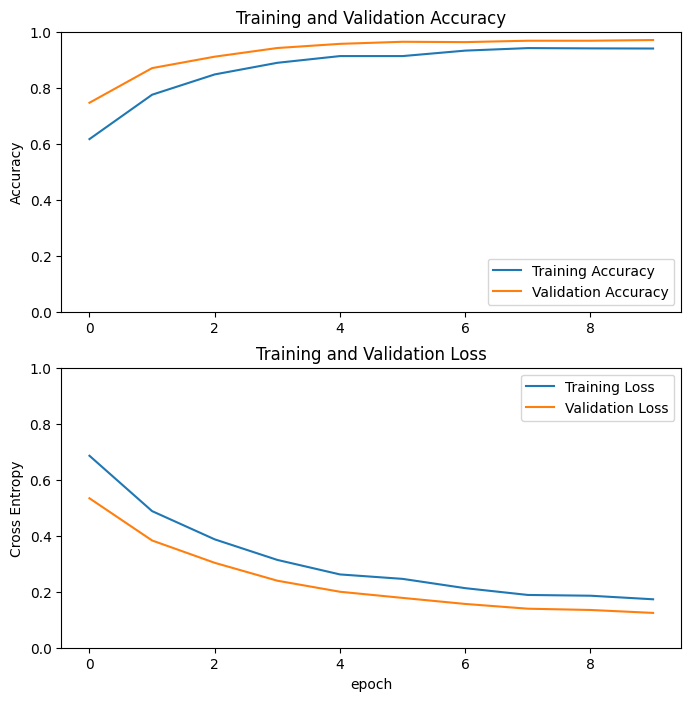

In [46]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 507ms/step - accuracy: 0.7728 - loss: 0.4542 - val_accuracy: 0.9827 - val_loss: 0.0816
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 491ms/step - accuracy: 0.8884 - loss: 0.2552 - val_accuracy: 0.9802 - val_loss: 0.0731
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 496ms/step - accuracy: 0.9407 - loss: 0.1772 - val_accuracy: 0.9814 - val_loss: 0.0591
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.9461 - loss: 0.1450 - val_accuracy: 0.9827 - val_loss: 0.0567
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.9495 - loss: 0.1455 - val_accuracy: 0.9839 - val_loss: 0.0448
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 502ms/step - accuracy: 0.9573 - loss: 0.1193 - val_accuracy: 0.9802 - val_loss: 0.0507
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.9687 - loss: 0.0982 - val_accuracy: 0.9851 - val_loss: 0.0434
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 485ms/step - accuracy: 0.9571 - loss: 0.0960 - 

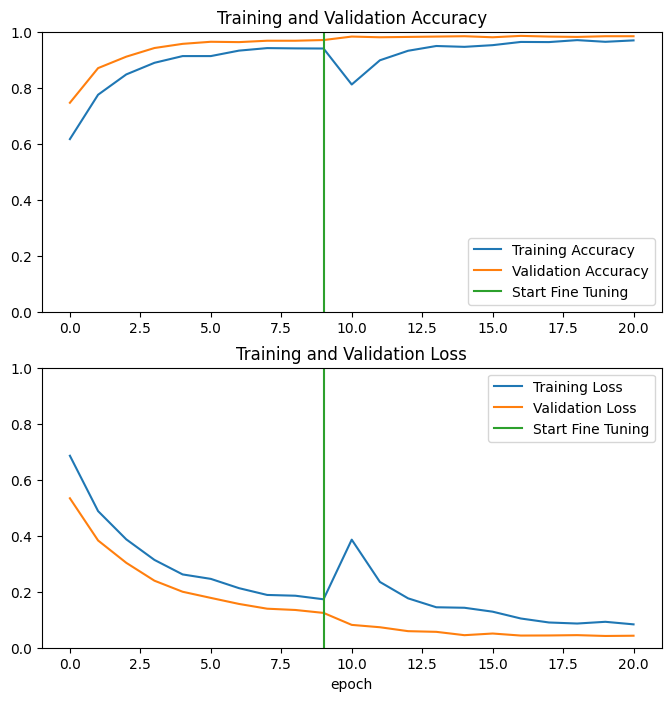

In [47]:
# Fine-tuning
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
    # Recompile the model with a lower learning rate
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
            metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                        epochs=total_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=validation_dataset)

# Plot the fine-tuning learning curves
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate the model on the test set and make some prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.9856 - loss: 0.0374
Test accuracy: 0.9895833134651184
Raw predictions:
 [9.9989855e-01 9.9994880e-01 9.3461257e-01 8.8484287e-03 9.9999070e-01
 7.4957462e-04 6.3005476e-03 5.8004120e-03 9.9819136e-01 2.4870171e-03
 9.9991435e-01 4.5402419e-05 2.3698028e-04 9.9998087e-01 3.0387306e-04
 9.9993110e-01 1.2089825e-03 9.9162036e-01 1.3577650e-04 9.9999481e-01
 9.9948037e-01 2.4229429e-04 9.9937552e-01 3.7343577e-02 9.9990010e-01
 9.9935347e-01 9.9873161e-01 3.3173786e-04 1.4417363e-02 5.3562707e-04
 1.5562937e-04 9.9997914e-01]
Binary predictions:
 [1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1]
Labels:
 [1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1]


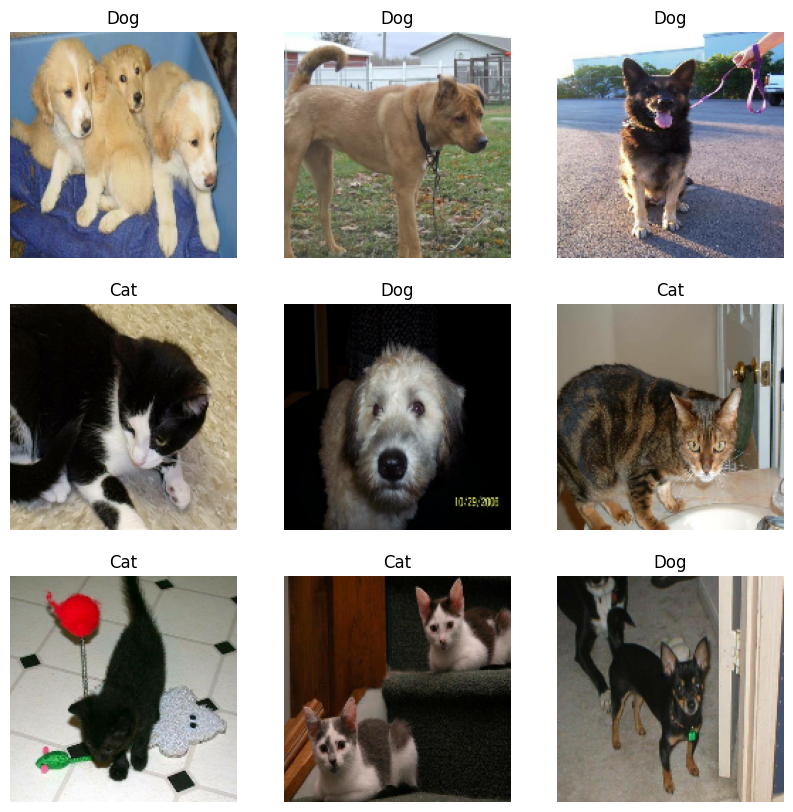

In [65]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy:', accuracy)

# Predictions on a batch of test images
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
raw_predictions = model.predict_on_batch(image_batch).flatten()
binary_predictions = tf.where(raw_predictions < 0.5, 0, 1)

print('Raw predictions:\n', raw_predictions)
print('Binary predictions:\n', binary_predictions.numpy())
print('Labels:\n', label_batch)

# Plot predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Dog' if binary_predictions[i] == 1 else 'Cat')
    plt.axis("off")
plt.show()


## Performance Summary
I will use the VGG model with a single block after having implemented the best of Data augmentation and Dropouts to compare performance with the MobileNet V2 model.



### VGG Model after Improvement (Data Augmentation and Dropout):

**Epoch 1-50:**
- **Training Accuracy:** Ranges from 49.71% to 73.60%
- **Training Loss:** Ranges from 0.5198 to 0.8223
- **Validation Accuracy:** Ranges from 54.95% to 69.31%
- **Validation Loss:** Ranges from 0.5839 to 0.6876

**Performance Analysis:**
- The VGG model shows an improvement in both training and validation accuracy over epochs, indicating that data augmentation and dropout layers effectively helped in reducing overfitting and improving generalization.

### MobileNet V2 Model after Training:

**Epoch 1-50:**
- **Training Accuracy:** Ranges from 77.28% to 97.67%
- **Training Loss:** Ranges from 0.0714 to 0.4542
- **Validation Accuracy:** Ranges from 98.02% to 98.39%
- **Validation Loss:** Ranges from 0.0420 to 0.0816

**Performance Analysis:**
- MobileNet V2 demonstrates significantly higher accuracy and lower loss compared to the VGG model, especially towards the later epochs. This indicates that the pre-trained MobileNet V2, even without fine-tuning, performed very well on the task.

### MobileNet V2 Model after Fine-Tuning:

**Epoch 10-20:**
- **Training Accuracy:** Ranges from 88.84% to 97.67%
- **Training Loss:** Ranges from 0.0714 to 0.2552
- **Validation Accuracy:** Ranges from 98.02% to 98.51%
- **Validation Loss:** Ranges from 0.0428 to 0.0816

**Performance Analysis:**
- Fine-tuning further improves both training and validation accuracy, suggesting that fine-tuning allows the model to adapt better to the specific task, resulting in even higher performance.

### Summary and Comparison:

- **VGG Model:** After improvement with data augmentation and dropout, achieved moderate accuracy but showed some inconsistency in validation performance compared to training.
  
- **MobileNet V2 Model:** Initially performed very well with high accuracy and low loss even before fine-tuning. After fine-tuning, the accuracy improved further, demonstrating the effectiveness of transfer learning and fine-tuning on this task.

- **Comparison:** MobileNet V2 outperformed the VGG model consistently across all stages (initial training and fine-tuning). It achieved higher accuracy and lower loss, indicating that for this task, leveraging a pre-trained model like MobileNet V2 and fine-tuning it yields superior results compared to training a VGG model from scratch with data augmentation.

This comparison highlights the benefits of using transfer learning, especially with models like MobileNet V2, in tasks where labeled data is limited or computational resources are constrained.
